# A/B Testing Course

## Lesson 4. Desing Testing

### Homework

#### Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from scipy.interpolate import interp1d

In [3]:
from scipy.stats import norm, ttest_ind

In [4]:
import random

#### Import Data

In [5]:
URL_BASE = ''

def read_database(file_name):
    return pd.read_csv(os.path.join(URL_BASE, file_name))

In [6]:
df_sales = read_database('2022-04-01T12_df_sales.csv')
df_sales['date'] = pd.to_datetime(df_sales['date'])

#### Data Description

df_sales - information about purchases, one row represents one order:
- sale_id - purchase identifier;
- date - date of purchase;
- count_pizza - number of pizzas in the order;
- count_drink - number of drinks in the order;
- price - order price;
- user_id - user identifier.   

#### Checking Data

In [7]:
df_sales.head()

,sale_id,date,count_pizza,count_drink,price,user_id
0,1000001,2022-02-04 10:00:24,1,0,720,1c1543
1,1000002,2022-02-04 10:02:28,1,1,930,a9a6e8
2,1000003,2022-02-04 10:02:35,3,1,1980,23420a
3,1000004,2022-02-04 10:03:06,1,1,750,3e8ed5
4,1000005,2022-02-04 10:03:23,1,1,870,cbc468


In [8]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203847 entries, 0 to 203846
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   sale_id      203847 non-null  int64         
 1   date         203847 non-null  datetime64[ns]
 2   count_pizza  203847 non-null  int64         
 3   count_drink  203847 non-null  int64         
 4   price        203847 non-null  int64         
 5   user_id      203847 non-null  object        
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 9.3+ MB


#### Task 1. 

Suppose all users who made purchases before March 28th are included in our A/B test.

The target metric is the average revenue per customer during the experiment. We will calculate the target metric for the week from March 21st to March 28th. The significance level is 0.05. The criterion is Student's t-test. The group size is 1000. The expected effect is an increase in average revenue by 10%.

We need to estimate the probabilities of type II errors for three ways of adding the effect:
1. Adding a constant to all values;
1. Multiplying all values by a constant;
1. Adding a constant to 2.5% of values.

Enter the numbers of the methods of adding the effect in order of increasing estimation of the probability of type II error. For example, if the estimation of the probability of error is the lowest when adding a constant to all values, and the highest when adding a constant to 2.5% of values, the answer would be: 123.

In [9]:
# filtering data by date
sales_filt = df_sales[(df_sales['date'] >= '2022-03-21') & \
                      (df_sales['date'] < '2022-03-28')]

In [10]:
# function to plot p-value graphs
def plot_pvalue_ecdf(pvalues, title=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if title:
        plt.suptitle(title)

    sns.histplot(pvalues, ax=ax1, bins=20, stat='density')
    ax1.plot([0,1],[1,1], 'k--')
    ax1.set(xlabel='p-value', ylabel='Density')

    sns.ecdfplot(pvalues, ax=ax2)
    ax2.plot([0,1],[0,1], 'k--')
    ax2.axvline(x=0.05, color='grey')
    
    # Define the x value you want to get the y value for
    x = 0.05
    line = ax2.get_lines()[0]
    f = interp1d(line.get_xdata(), line.get_ydata())
    y = f(x)
    print(f"The Beta value for alpha={x} is {y:.2f}")
    
    ax2.set(xlabel='p-value', ylabel='Probability')
    ax2.grid()

Adding a constant to all values.

The Beta value for alpha=0.05 is 0.93


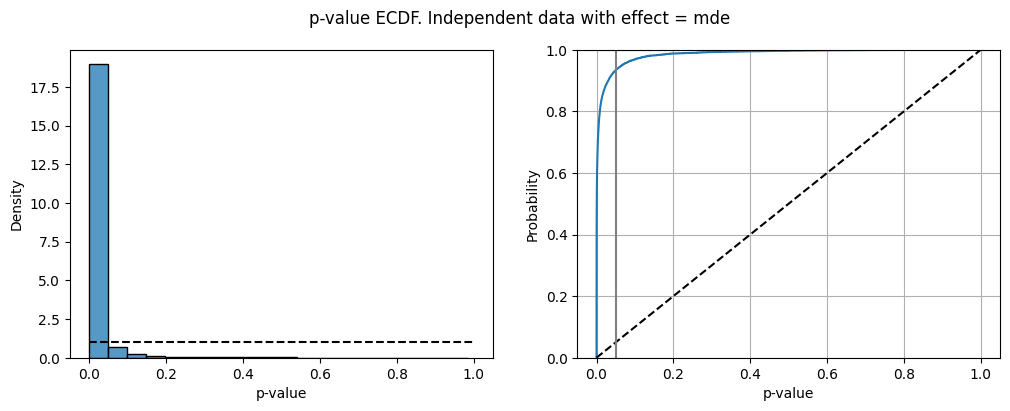

In [11]:
sample_size = 1000
alpha = 0.05
effect = 0.1


p_values = []
grouped_sales = sales_filt.groupby('user_id', as_index=False).agg({'price': 'sum'}).reset_index()
mean = grouped_sales['price'].mean()
std = grouped_sales['price'].std()
users = sales_filt['user_id'].unique().tolist()
for _ in range(10000):
    np.random.shuffle(users)
    group_a = random.sample(users, sample_size)
    group_b = random.sample(users, sample_size)
    sales_a = grouped_sales[grouped_sales['user_id'].isin(group_a)]['price']
    sales_b = grouped_sales[grouped_sales['user_id'].isin(group_b)]['price']
    sales_b = sales_b + mean * effect
    _, p_val = ttest_ind(sales_a, sales_b)
    p_values.append(p_val)
plot_pvalue_ecdf(p_values, 'p-value ECDF. Independent data with effect = mde')

Multiplying all values by a constant.

The Beta value for alpha=0.05 is 0.91


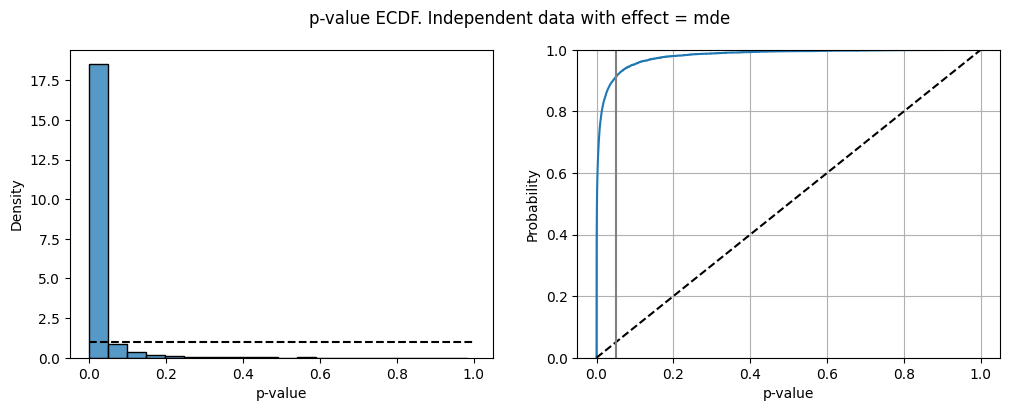

In [12]:
p_values = []
grouped_sales = sales_filt.groupby('user_id', as_index=False).agg({'price': 'sum'}).reset_index()
users = sales_filt['user_id'].unique().tolist()
for _ in range(10000):
    np.random.shuffle(users)
    group_a = random.sample(users, sample_size)
    group_b = random.sample(users, sample_size)
    sales_a = grouped_sales[grouped_sales['user_id'].isin(group_a)]['price']
    sales_b = grouped_sales[grouped_sales['user_id'].isin(group_b)]['price']
    sales_b = sales_b * (1 + effect)
    _, p_val = ttest_ind(sales_a, sales_b)
    p_values.append(p_val)
plot_pvalue_ecdf(p_values, 'p-value ECDF. Independent data with effect = mde')

Adding a constant to 2.5% of data.

The Beta value for alpha=0.05 is 0.86


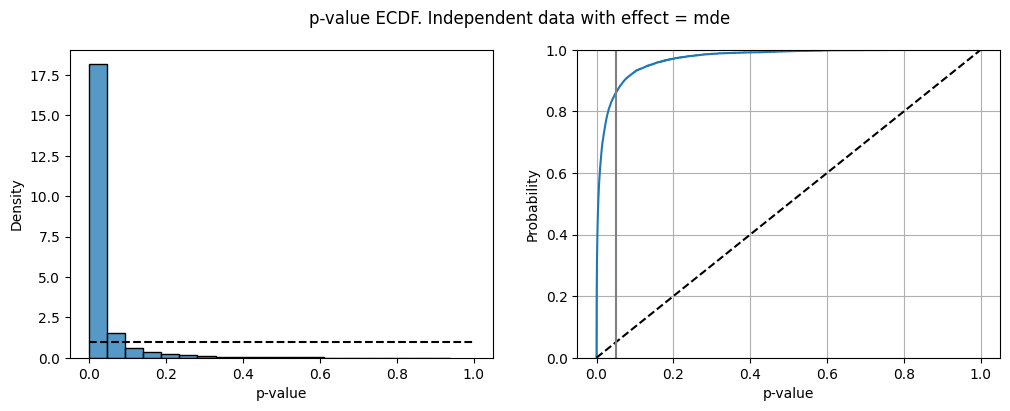

In [13]:
p_values = []
grouped_sales = sales_filt.groupby('user_id', as_index=False).agg({'price': 'sum'}).reset_index()
users = sales_filt['user_id'].unique().tolist()
for _ in range(10000):
    np.random.shuffle(users)
    group_a = random.sample(users, sample_size)
    group_b = random.sample(users, sample_size)
    sales_a = grouped_sales[grouped_sales['user_id'].isin(group_a)]['price']
    sales_b = grouped_sales[grouped_sales['user_id'].isin(group_b)]['price']
    indexes = np.random.choice(np.arange(sample_size), int(sample_size * 0.025), False)
    add_value = effect * mean * sample_size / len(indexes)
    sales_b1 = sales_b[:len(indexes)] + add_value
    sales_b2 = sales_b[len(indexes):]
    sales_b = sales_b1.append(sales_b2)
    _, p_val = ttest_ind(sales_a, sales_b)
    p_values.append(p_val)
plot_pvalue_ecdf(p_values, 'p-value ECDF. Independent data with effect = mde')

#### Task 2. 

Today we need to implement the code to estimate the probabilities of type I and type II errors.   
Write the method `_estimate_errors` of the class `ExperimentsService`.

In [14]:
import numpy as np
import pandas as pd
from pydantic import BaseModel
from scipy import stats


class Design(BaseModel):
    """Data class with a description of experiment parameters.
    
    statistical_test - type of statistical test. ['ttest']
    effect - effect size in percentage
    alpha - significance level
    beta - allowable probability of type II error
    sample_size - group size
    """
    statistical_test: str = 'ttest'
    effect: float
    alpha: float = 0.05
    beta: float = 0.1
    sample_size: int


class ExperimentsService:

    def get_pvalue(self, metrics_a_group, metrics_b_group, design):
        """Applies a statistical test and returns p-value.
        
        :param metrics_a_group (np.array): an array of metric values for group A
        :param metrics_b_group (np.array): an array of metric values for group B
        :param design (Design): an object containing experiment parameters data
        :return (float): p-value
        """
        if design.statistical_test == 'ttest':
            _, pvalue = stats.ttest_ind(metrics_a_group, metrics_b_group)
            return pvalue
        else:
            raise ValueError('Wrong design.statistical_test')

    def _create_group_generator(self, metrics, sample_size, n_iter):
        """Random groups generator.
        
        :param metrics (pd.DataFame): a table with metrics, columns=['user_id', 'metric'].
        :param sample_size (int): group size (number of users in the group).
        :param n_iter (int): number of iterations of random group generation.
        :return (np.array, np.array): two arrays with metric values in groups.
        """
        user_ids = metrics['user_id'].unique()
        for _ in range(n_iter):
            a_user_ids, b_user_ids = np.random.choice(user_ids, (2, sample_size), False)
            a_metric_values = metrics.loc[metrics['user_id'].isin(a_user_ids), 'metric'].values
            b_metric_values = metrics.loc[metrics['user_id'].isin(b_user_ids), 'metric'].values
            yield a_metric_values, b_metric_values

    def _estimate_errors(self, group_generator, design, effect_add_type):
        """Estimating the probabilities of Type I and Type II errors.

        :param group_generator: generator of metric values for two groups.
        :param design (Design): object with experiment parameters description.
        :param effect_add_type (str): way of adding effect for group B.
            - 'all_const' - increase all values in group B by a constant (b_metric_values.mean() * effect / 100).
            - 'all_percent' - increase all values in group B by a factor of (1 + effect / 100).
        :return pvalues_aa (list[float]), pvalues_ab (list[float]), first_type_error (float), second_type_error (float):
            - pvalues_aa, pvalues_ab - lists of p-value values
            - first_type_error, second_type_error - estimates of the probabilities of Type I and Type II errors.
        """
        # YOUR_CODE_HERE
        pvalues_aa = []
        pvalues_ab = []
        eff = design.effect
        alpha = design.alpha
        
        for value in group_generator:
            group_a, group_b = value
            
            pvalues_aa.append(self.get_pvalue(group_a, group_b, design))

            if effect_add_type == 'all_const':
                effect = group_b.mean() * eff / 100
                group_b = group_b + effect
            elif effect_add_type == 'all_percent':
                effect = 1 + eff / 100
                group_b = group_b * effect

            pvalues_ab.append(self.get_pvalue(group_a, group_b, design))
        
        first = [x for x in pvalues_aa if x < alpha]
        second = [x for x in pvalues_ab if x > alpha]
        
        first_type_error = len(first) / len(pvalues_aa)
        second_type_error = len(second) / len(pvalues_ab)
        
        return pvalues_aa, pvalues_ab, first_type_error, second_type_error

    def estimate_errors(self, metrics, design, effect_add_type, n_iter):
        """Estimating the probabilities of Type I and Type II errors.

            :param metrics (pd.DataFrame): a table with metrics, columns=['user_id', 'metric'].
            :param design (Design): an object with data describing the experiment parameters.
            :param effect_add_type (str): the way to add the effect for group B.
                - 'all_const' - increase all values in group B by a constant (b_metric_values.mean() * effect / 100).
                - 'all_percent' - increase all values in group B by (1 + effect / 100) times.
            :param n_iter (int): the number of iterations of generating random groups.
            :return pvalues_aa (list[float]), pvalues_ab (list[float]), first_type_error (float), second_type_error (float):
                - pvalues_aa, pvalues_ab - lists with pvalue values
                - first_type_error, second_type_error - estimates of the probabilities of type I and II errors.
        """
        group_generator = self._create_group_generator(metrics, design.sample_size, n_iter)
        return self._estimate_errors(group_generator, design, effect_add_type)


if __name__ == '__main__':
    _a = np.array([1., 2, 3, 4, 5])
    _b = np.array([1., 2, 3, 4, 10])
    group_generator = ([a, b] for a, b in ((_a, _b),))
    design = Design(effect=50., sample_size=5)
    effect_add_type = 'all_percent'

    ideal_pvalues_aa = [0.579584]
    ideal_pvalues_ab = [0.260024]
    ideal_first_type_error = 0.
    ideal_second_type_error = 1.

    experiments_service = ExperimentsService()
    pvalues_aa, pvalues_ab, first_type_error, second_type_error = experiments_service._estimate_errors(
        group_generator, design, effect_add_type
    )
    np.testing.assert_almost_equal(ideal_pvalues_aa, pvalues_aa, decimal=4)
    np.testing.assert_almost_equal(ideal_pvalues_ab, pvalues_ab, decimal=4)
    assert ideal_first_type_error == first_type_error
    assert ideal_second_type_error == second_type_error
    print('simple test passed')

simple test passed
